In [1]:
%run util.py

/Users/choiyoungrok/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
#-*- coding: utf-8 -*-
from konlpy.utils import pprint
from konlpy.tag import *
import datetime
import time
import csv
import sys
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pylab as plt
import matplotlib.dates as mdates
import seaborn as sns
import dateutil
import random

from sklearn.cluster import KMeans, MiniBatchKMeans, AffinityPropagation, DBSCAN, AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD
from sklearn import metrics

In [3]:
# set to show all text in the cell
pd.set_option('display.max_colwidth', -1)

# 한글 표시
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="/Library/Fonts/NanumGothic.ttf").get_name()
rc('font', family=font_name)

<br>
# 데이터 소개

In [4]:
# file path
PATH = '../dataset/physiogel.csv'
df0 = pd.read_csv(PATH)
df00 = df0.dropna(subset=['text'])
temp = [x.strip().decode('utf-8') for x in df00['text'].values] # erase back and foward spaces/ decoding to unicode 
df = pd.DataFrame(data=temp, index=df00['uid'], columns=['text'])
df

text
uid                                                                                                                                                                                                                                                                                                  
28618460  매번 사용하는 제품인데 저렴하게 잘 삿습니당                                                                                                                                                                                                                                                                   
28608506  몇 년째 쓰는 제품이예요~\n다른 기초화장품 없이 피지오겔크링과 선크림으로\n피부가 좋아졌 어요~~ 여름이면 항상 얼굴이  따끔거렸는데 \n그것도 다 없어지고~  암튼 전 화장품은 이거 하나만발라요~\n자극도 없고 완전 좋은 제품입니다~~                                                                                                                                                      
28584972  조금 기름진느낌이 없지않아있어요                                                                                                                                                                                                                                                                          
28584914  가격부담이 되도 계속 쓰고 있는 피지오겔 크림\n귀찮을때 이거 하나만 바르고 자도 다음날 화장 잘먹고 얼굴에서 광나요\n전 밤엔 듬뿍 아침엔 적당량만 발라요(집순이일땐 듬뿍)\n건성 민감성 피부에 좋아요 무향에 자극없고 보습력 좋아요\n로켓배송 덕분에 빠르게 쓸 수 있어서 좋았어요                                                                                                                              
28581673  촉촉해서 수분크림대신바르는데 좋아요                                                                                                                                                                                                                                                                        
28567308  배송빨라 좋네요                                                                                                                                                                                                                                                                                   
28542147  1. 배송 : 로켓 아니어도 괜찬은데, 다음날 바로 도착헸네요. 배송기사님 감사합니다.\n2. 제품 : 피지오겔 크림 똑같은 것으로 또 주문해서 사용합니다. 저는 민감피부라 무향을 선호해서 무향이라 좋고, 사계절 내내 사용하기 무리없구요. 여름엔 생각보단 덜 번들거리고, 겨울엔 저녁에 바르면 아침까지 건조함이 없어 좋습니다. 주문하면서 사용기한 내심 걱정했는데, 이번에도 안심이네요. (제가 사용하는 기간까지 넉넉해요-유통기한이 내년5월?6월까지인것 같았어요. 제품받고 며칠지난터라 정확한 기억이 안남.)
28465156  피지오겔~7년째사용중~~                                                                                                                                                                                                                                                                              
28463679  항상 쓰던 제품입니다 좋아요~~                                                                                                                                                                                                                                                                          
28454963  배송도 빠르고 좋으네영                                                                                                                                                                                                                                                                               
28418125  좋네요                                                                                                                                                                                                                                                                                        
28397315  바르고 30분이 지나서 얼굴을 보니 빨갛더라구요 너무 놀래서 씻고나서 리뷰를 보는데 참... 건성분들은 모르겠지만 중성 지성 분들은 사지마세요 저는 겨을에 바디로션 대신 바를려구요..^^                                                                                                                                                                                   
28371541  보습은 완전 잘돼요! 촉촉한 느낌이고 유분기는 거의 없어요                                                                                                                                   

In [5]:
corpus = df.text.values
corpus.shape

(3072,)

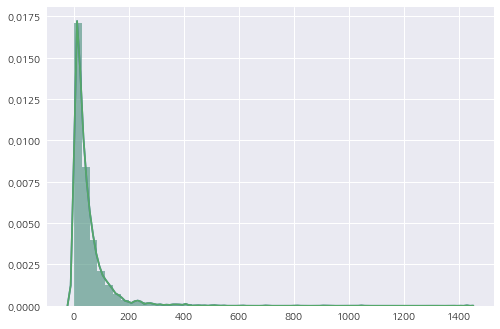

In [54]:
sns.distplot([len(x) for x in corpus])
plt.show()

In [57]:
txt_len = pd.Series([len(x) for x in corpus])

In [62]:
corpus0 = df.text.values[txt_len < 20]
len(corpus0)

1080

In [65]:
corpus1 = df.text.values[(txt_len >= 20) & (txt_len < 40)]
len(corpus1)

735

In [70]:
corpus2 = df.text.values[(txt_len >= 40) & (txt_len < 60)]
len(corpus2)

440

In [69]:
corpus3 = df.text.values[(txt_len >= 60) & (txt_len < 80)]
len(corpus3)

268

In [71]:
corpus4 = df.text.values[(txt_len >= 80) & (txt_len < 100)]
len(corpus4)

158

In [72]:
corpus5 = df.text.values[(txt_len >= 100)]
len(corpus5)

391

In [74]:
len(corpus0) + len(corpus1) + len(corpus2) + len(corpus3) + len(corpus4) + len(corpus5)

3072

<br>
# 형태소 분석

In [6]:
twitter = Twitter()

In [7]:
def nav_tokenizer(corpus):
    pos = twitter.pos(corpus)
    res = [x[0] for x in pos if (x[1] == u'Noun' or x[1] == u'Adjective' or x[1] == u'Verb')]
    return res

In [8]:
stopwords = [u'피', u'지오', u'겔']

In [9]:
vect = TfidfVectorizer(tokenizer=nav_tokenizer, stop_words=stopwords)
vect.fit(corpus)
print("token n/a/v: %d" % len(vect.vocabulary_))

token n/a/v: 4796


In [17]:
X = vect.transform(corpus).toarray()

<br>
# Hierachical Clustering(ward)

In [45]:
cluster = AgglomerativeClustering(n_clusters=10, affinity='euclidean', linkage='ward')
cluster.fit(X)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward',
            memory=Memory(cachedir=None), n_clusters=10,
            pooling_func=<function mean at 0x113d3aed8>)

In [46]:
print("Silhouette Coefficient: %0.3f" % silhouette_score(X, cluster.labels_))

Silhouette Coefficient: 0.032


In [47]:
dfRes = pd.DataFrame(corpus, columns=['text'])
dfRes['label'] = cluster.labels_
for i in range(len(dfRes.label.unique())):
    print('label {}: {}'.format(i, len(dfRes.loc[dfRes['label'] == i])))

label 0: 574
label 1: 129
label 2: 41
label 3: 17
label 4: 2036
label 5: 37
label 6: 33
label 7: 149
label 8: 28
label 9: 28


In [48]:
repr_all(dfRes.loc[dfRes['label'] == 0])

text  \
0     매번 사용하는 제품인데 저렴하게 잘 삿습니당                                                                                                                                                                                                                                                                                                                                                               
5     배송빨라 좋네요                                                                                                                                                                                                                                                                                                                                                                               
17    상품 배송 만족합니다                                                                                                                                                                                                                                                                                                                                                                            
18    역쉬 보습 짱!                                                                                                                                                                                                                                                                                                                                                                               
19    배송 및 상품 만족스럽습니다.                                                                                                                                                                                                                                                                                                                                                                       
23    잘받았습니다 좋은상풒                                                                                                                                                                                                                                                                                                                                                                            
24    늘 쓰는 제품이에요. 쿠팡에서 저렴하게 잘 구입했어요.                                                                                                                                                                                                                                                                                                                                                         
28    한상 쓰는 로션이에요 \n최저가에요 \n배송빨라요 \n믿고쓰는 피지오겔                                                                                                                                                                                                                                                                                                                                                
30    상품진짜엿같아요 개엿 사지마세요쿡방상품                                                                                                                                                                                                                                                                                                                                                                  
33    아이들과 같이쓰려고 구매했어요. 오프라인보다 싸요                                                                                                                                                                                                                                                                                                                                                            
43    지인 추천으로 쓰게된 화장품이에용\n\n아직 몇 번 사용하지 않아 잘 모르지만\n\n지인에게 추천받았을 때 \n\n성분이 좋다해서 받았어용 \n\n그래서 그런지 발랐을 때 순한 느낌은 있어용!\n\n로켓배송이라 주문 다음날 받았어용 ㅎㅎ                                  

'574 rows printed'

In [19]:
repr_all(dfRes.loc[dfRes['label'] == 1])

text  \
8     항상 쓰던 제품입니다 좋아요~~                                                                                                                     
25    넘 잘 쓰고 있어요 감사합니다                                                                                                                      
29    늘 쓰던거라 믿고 구매합니다                                                                                                                       
49    이제품만씁니다                                                                                                                               
81    늘쓰던거.ㅎ                                                                                                                                
100   좋아요항상이제품만써요~                                                                                                                          
113   피지오겔 아주 잘쓰고있어요!!!!!!!!!!!\n보습려고 최고고 항상 쓰던거 구매해서 잘쓰고있습니다 ㅎㅎ                                                                            
132   보습력 좋아요 꾸준히 쓰려고요                                                                                                                      
137   꾸준히쓰고있어요                                                                                                                              
139   항상 쿠팡에서 주문합니다 ㅋㅋ 최고예요                                                                                                                 
159   항상쓰던거라\n촉촉해요                                                                                                                          
161   믿고쓰는 피지오겔\n믿고사는 쿠팡임니당\n빠른배송 최고네요                                                                                                      
193   항상 쓰던 제품이라 좋아요                                                                                                                        
261   믿고사는피지오겔                                                                                                                              
300   피지오겔은 항상 좋음                                                                                                                           
327   역시 피지오겔입니다. 크림타입이고 발림성 좋고 촉촉함은 정말 오래갑니다. 믿고 쓰는 제품입니다                                                                                  
356   잘쓰고있습니다                                                                                                                               
369   늘 쓰고있는 제품입니다. 신랑이 손이 심하게 건조해서 여러가지 제품을 써봤는데 피지오겔이 가장 효과가 좋았어요. 휴대하기 간편한 사이즈입니다. 배송도 빠르고 좋았어요~~                                        
392   항상쓰는 피지오겔 크림 ㅎㅎ 좋아요                                                                                                                   
410   항상 잘쓰고 있어요                                                                                                                            
443   좋아요 믿고쓰는피지오겔                                                                                                                          
448   항상 구입하는 제품이어서 믿고 구매합니다^^                                                                                                              
456   원래쓰는 제품이라 믿고주문했어요~잘받았습니다                                                                                                              
476   다른 화장품 안쓰고 있어요 보습 좋아요                                                                                                                 
499   믿고쓰는 상품ㅋ                                                                                                                              
558   늘 쓰는 제품이에요\n수분크림으로 써요                                                                                                                 
561   피지오겔은 항상 옳습니다                                                                                                                         
599   항상 쓰던 제품이라 이번에도 역시 만족하고 쓰고 있어요~~                                                                                                      
615   늘 구매하는 상품입니다. 쿠팡이 젤ㅅ가격 조아요            

'129 rows printed'

In [21]:
pprint(corpus[8])

항상 쓰던 제품입니다 좋아요~~


In [22]:
pprint(corpus[100])

좋아요항상이제품만써요~


In [25]:
repr_all(dfRes.loc[dfRes['label'] == 2])

text  label
64    촉촉하고 좋습니다^^               2    
115   ㆍ늘쓰던거에요...촉촉하니좋아요         2    
199   좋아요 너무좋아요                 2    
212   촉촉하니 좋으네요                 2    
420   피지오겔 너무 좋아요               2    
531   촉촉하니 좋아요 ^^               2    
657   상품 촉촉하니  좋아요~~            2    
680   촉촉하고\n좋아요                 2    
782   촉촉하고 좋아요                  2    
859   촉촉하고 좋네요. ^^              2    
863   촉촉하니 너무좋아요~               2    
1136  촉촉하고 보습좋아요                2    
1149  아기한테 너무 좋아요               2    
1206  촉촉하고 좋아요                  2    
1250  촉촉하고 좋아요^^                2    
1294  촉촉하니 괜찮아요~^^              2    
1370  촉촉하고 좋아요:-)               2    
1425  너무 좋아용                    2    
1447  촉촉하니 좋아용~~                2    
1454  촉촉하고좋아요!!                 2    
1616  촉촉하고 너무 좋아요^^             2    
1782  너무좋아요                     2    
2076  촉촉하고 좋아요                  2    
2161  너무너무좋음\n딱…좋음              2    
2179  수분이~너무좋으네요~^^             2    
2247  너무 좋아요!                   2    
2317  촉촉하고 너무좋아요 보습짱            2    
2398  너무좋아요                     2    
2431  촉촉하고 좋아요                  2    
2588  보습짱 너무좋아요                 2    
2693  너무좋아요~~^^                 2    
2722  촉촉하니 좋아요ㅎ                 2    
2725  너무너무 좋아요 보습이 너무 좋은듯해요/    2    
2768  건성들에게 최고 촉촉하니 좋습니다        2    
2771  아기랑 저랑 같이사용하는데 촉촉하니..좋아요  2    
2795  촉촉하니 좋아요~^^               2    
2830  촉촉하고 너무좋아요...             2    
2958  좋아요...촉촉하고~               2    
2977  촉촉하고좋아요                   2    
3026  너무 좋아요                    2    
3068  촉촉하니 좋습니다                 2

'41 rows printed'

In [29]:
repr_all(dfRes.loc[dfRes['label'] == 0])

text  \
0     매번 사용하는 제품인데 저렴하게 잘 삿습니당                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
1     몇 년째 쓰는 제품이예요~\n다른 기초화장품 없이 피지오겔크링과 선크림으로\n피부가 좋아졌 어요~~ 여름이면 항상 얼굴이  따끔거렸는데 \n그것도 다 없어지고~  암튼 전 화장품은 이거 하나만발라요~\n자극도 없고 완전 좋은 제품입니다~~                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
2     조금 기름진느낌이 없지않아있어요                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

'2627 rows printed'

In [34]:
pprint(nav_tokenizer(corpus[64]))

[촉촉하고, 좋]


In [38]:
pprint(nav_tokenizer(corpus[282]))

[세딸,
 엄마,
 쓰는,
 촉촉하니,
 좋,
 특별히,
 건조한,
 분,
 여름,
 쓰,
 좀,
 무거운,
 같아]


<br>
# Distance

In [14]:
from sklearn.neighbors import DistanceMetric

In [18]:
len(X)

3072

In [36]:
dist = DistanceMetric.get_metric('manhattan')
dist.pairwise([X[64], X[2]])

array([[ 0.        ,  3.52389809],
       [ 3.52389809,  0.        ]])

<br>
# Fuzzy K-means

In [111]:
fuzzy_kmeans = FuzzyKMeans(k=10, m=10)
fuzzy_kmeans.fit(X)

FuzzyKMeans(k=10, m=10, max_iter=100, random_state=0, tol=0.0001)

In [112]:
pd.Series(fuzzy_kmeans.labels_).unique()

array([9, 1, 6, 4, 8])

In [113]:
print("Silhouette Coefficient: %0.3f" % silhouette_score(X, fuzzy_kmeans.labels_))

Silhouette Coefficient: -0.006


In [103]:
import numpy as np
import pylab as pl

from sklearn.base import BaseEstimator
from sklearn.utils import check_random_state
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans as KMeansGood
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances
from sklearn.datasets.samples_generator import make_blobs

##############################################################################
# Generate sample data
np.random.seed(0)

batch_size = 45
centers = [[1, 1], [-1, -1], [1, -1]]
n_clusters = len(centers)
X, labels_true = make_blobs(n_samples=1200, centers=centers, cluster_std=0.3)

class KMeans(BaseEstimator):

    def __init__(self, k, max_iter=100, random_state=0, tol=1e-4):
        self.k = k
        self.max_iter = max_iter
        self.random_state = random_state
        self.tol = tol

    def _e_step(self, X):
        self.labels_ = euclidean_distances(X, self.cluster_centers_,
                                     squared=True).argmin(axis=1)

    def _average(self, X):
        return X.mean(axis=0)

    def _m_step(self, X):
        X_center = None
        for center_id in range(self.k):
            center_mask = self.labels_ == center_id
            if not np.any(center_mask):
                # The centroid of empty clusters is set to the center of
                # everything
                if X_center is None:
                    X_center = self._average(X)
                self.cluster_centers_[center_id] = X_center
            else:
                self.cluster_centers_[center_id] = \
                    self._average(X[center_mask])

    def fit(self, X, y=None):
        n_samples = X.shape[0]
        vdata = np.mean(np.var(X, 0))

        random_state = check_random_state(self.random_state)
        self.labels_ = random_state.permutation(n_samples)[:self.k]
        self.cluster_centers_ = X[self.labels_]

        for i in xrange(self.max_iter):
            centers_old = self.cluster_centers_.copy()

            self._e_step(X)
            self._m_step(X)

            if np.sum((centers_old - self.cluster_centers_) ** 2) < self.tol * vdata:
                break

        return self

class KMedians(KMeans):

    def _e_step(self, X):
        self.labels_ = manhattan_distances(X, self.cluster_centers_).argmin(axis=1)

    def _average(self, X):
        return np.median(X, axis=0)

class FuzzyKMeans(KMeans):

    def __init__(self, k, m=2, max_iter=100, random_state=0, tol=1e-4):
        """
        m > 1: fuzzy-ness parameter
        The closer to m is to 1, the cluster to hard kmeans.
        The bigger m, the fuzzier (converge to the global cluster).
        """
        self.k = k
        assert m > 1
        self.m = m
        self.max_iter = max_iter
        self.random_state = random_state
        self.tol = tol

    def _e_step(self, X):
        D = 1.0 / euclidean_distances(X, self.cluster_centers_, squared=True)
        D **= 1.0 / (self.m - 1)
        D /= np.sum(D, axis=1)[:, np.newaxis]
        # shape: n_samples x k
        self.fuzzy_labels_ = D
        self.labels_ = self.fuzzy_labels_.argmax(axis=1)

    def _m_step(self, X):
        weights = self.fuzzy_labels_ ** self.m
        # shape: n_clusters x n_features
        self.cluster_centers_ = np.dot(X.T, weights).T
        self.cluster_centers_ /= weights.sum(axis=0)[:, np.newaxis]

    def fit(self, X, y=None):
        n_samples, n_features = X.shape
        vdata = np.mean(np.var(X, 0))

        random_state = check_random_state(self.random_state)
        self.fuzzy_labels_ = random_state.rand(n_samples, self.k)
        self.fuzzy_labels_ /= self.fuzzy_labels_.sum(axis=1)[:, np.newaxis]
        self._m_step(X)

        for i in xrange(self.max_iter):
            centers_old = self.cluster_centers_.copy()

            self._e_step(X)
            self._m_step(X)

            if np.sum((centers_old - self.cluster_centers_) ** 2) < self.tol * vdata:
                break

        return self


kmeans = KMeans(k=3)
kmeans.fit(X)

kmedians = KMedians(k=3)
kmedians.fit(X)

fuzzy_kmeans = FuzzyKMeans(k=3, m=3)
fuzzy_kmeans.fit(X)

fig = pl.figure()
colors = ['#4EACC5', '#FF9C34', '#4E9A06']

objects = (kmeans, kmedians, fuzzy_kmeans)

for i, obj in enumerate(objects):
    ax = fig.add_subplot(1, len(objects), i + 1)
    for k, col in zip(range(obj.k), colors):
        my_members = obj.labels_ == k
        cluster_center = obj.cluster_centers_[k]
        ax.plot(X[my_members, 0], X[my_members, 1], 'w',
                markerfacecolor=col, marker='.')
        ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
                                        markeredgecolor='k', markersize=6)
    ax.set_title(obj.__class__.__name__)

pl.show()